In [8]:
!pip install openai langchain langgraph pandas faiss-cpu langchain_openai langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.25
    Uninstalling langchain-0.3.25:
      Successfully uninstalled langchain-0.3.25


In [2]:
#creating sample dataset
import pandas as pd

data = [
    {"question": "How do I reverse a list in Python?", "answer": "Use list.reverse() or list[::-1]."},
    {"question": "What is a lambda function in Python?", "answer": "A lambda function is an anonymous function defined with the lambda keyword."},
    {"question": "How to install a package using pip?", "answer": "Run 'pip install package_name' in your terminal."},
    {"question": "What is the difference between a list and a tuple?", "answer": "Lists are mutable, tuples are immutable."},
    {"question": "How can I read a file in Python?", "answer": "Use open('filename') and read() or readline() methods."},
    {"question": "What is a dictionary in Python?", "answer": "A dictionary is a collection of key-value pairs."},
    {"question": "How do I handle exceptions in Python?", "answer": "Use try-except blocks to handle exceptions."},
    {"question": "What is the use of self in Python classes?", "answer": "'self' refers to the instance of the class."},
    {"question": "How do I merge two dictionaries in Python?", "answer": "Use the update() method or the ** unpacking operator."},
    {"question": "How to create a virtual environment in Python?", "answer": "Use 'python -m venv env_name'."}
]

df = pd.DataFrame(data)
df.to_csv("stackoverflow_qa.csv", index=False)
print("Sample Stack Overflow dataset created!")

Sample Stack Overflow dataset created!


In [3]:
df

,question,answer
0,How do I reverse a list in Python?,Use list.reverse() or list[::-1].
1,What is a lambda function in Python?,A lambda function is an anonymous function def...
2,How to install a package using pip?,Run 'pip install package_name' in your terminal.
3,What is the difference between a list and a tu...,"Lists are mutable, tuples are immutable."
4,How can I read a file in Python?,Use open('filename') and read() or readline() ...
5,What is a dictionary in Python?,A dictionary is a collection of key-value pairs.
6,How do I handle exceptions in Python?,Use try-except blocks to handle exceptions.
7,What is the use of self in Python classes?,'self' refers to the instance of the class.
8,How do I merge two dictionaries in Python?,Use the update() method or the ** unpacking op...
9,How to create a virtual environment in Python?,Use 'python -m venv env_name'.


In [1]:
from google.colab import userdata
openai_token = userdata.get('OPENAI_API_KEY')
import os
os.environ['OPENAI_API_KEY'] = openai_token

In [2]:
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langgraph.graph import StateGraph, END

In [4]:
import pandas as pd
df = pd.read_csv("stackoverflow_qa.csv")
qa_pairs = df.to_dict(orient="records")
docs = [f"Q: {row['question']}\nA: {row['answer']}" for row in qa_pairs]
embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_texts(docs, embeddings)

In [41]:
#Define retrieval and logging tools
def retrieve_answer(question):
    results = vectorstore.similarity_search_with_score(f"Q: {question}", k=1)
    if results:
        doc = results[0][0]
        return doc.page_content.split("A:")[-1].strip()
    return None

def log_unanswered(question, log_file="unanswered_questions.txt"):
    with open(log_file, "a") as f:
        f.write(question + "\n")
    return "Question logged for human review."

In [42]:
def retrieval_node(state):
    question = state["question"]
    answer = retrieve_answer(question)
    if answer:
        return {"answer": answer, "found": True}
    else:
        return {"question": question, "found": False}

def logging_node(state):
    question = state["question"]
    msg = log_unanswered(question)
    return {"answer": msg, "found": False}

In [43]:
#Build the graph with conditional routing
graph = StateGraph(dict)
graph.add_node("retrieval", retrieval_node)
graph.add_node("logger", logging_node)

# Conditional edge: if found, end; else, log
graph.add_conditional_edges(
    "retrieval",
    lambda state: "end" if state["found"] else "logger",
    {"end": END, "logger": "logger"}
)
graph.add_edge("logger", END)
graph.set_entry_point("retrieval")

qa_graph = graph.compile()

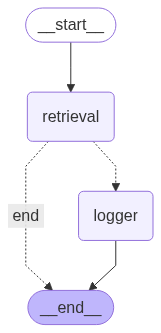

In [44]:
qa_graph

In [45]:
def ask_stackoverflow(question):
    result = qa_graph({"question": question})
    return result.get("answer", "Question logged for human review.")

In [46]:
print("Ask a Stack Overflow question (type 'exit' to quit):")
while True:
    user_q = input("Q: ")
    if user_q.lower() == "exit":
        break
    result = qa_graph.invoke({"question": user_q})
    answer = result.get("answer", "Question logged for human review.")
    print("A:", answer)

Ask a Stack Overflow question (type 'exit' to quit):
Q: What is a lambda function in Python?
A: A lambda function is an anonymous function defined with the lambda keyword.
Q: how can i reverse a list in python?
A: Use list.reverse() or list[::-1].
Q: can you give detailed steps for creating virtual environment in python?
A: Use 'python -m venv env_name'.
Q: exit


Debug

In [20]:
question = "What is a lambda function in Python?"
answer = retrieve_answer(question)

In [22]:
answer

In [23]:
vectorstore

In [24]:
docs

['Q: How do I reverse a list in Python?\nA: Use list.reverse() or list[::-1].',
 'Q: What is a lambda function in Python?\nA: A lambda function is an anonymous function defined with the lambda keyword.',
 "Q: How to install a package using pip?\nA: Run 'pip install package_name' in your terminal.",
 'Q: What is the difference between a list and a tuple?\nA: Lists are mutable, tuples are immutable.',
 "Q: How can I read a file in Python?\nA: Use open('filename') and read() or readline() methods.",
 'Q: What is a dictionary in Python?\nA: A dictionary is a collection of key-value pairs.',
 'Q: How do I handle exceptions in Python?\nA: Use try-except blocks to handle exceptions.',
 "Q: What is the use of self in Python classes?\nA: 'self' refers to the instance of the class.",
 'Q: How do I merge two dictionaries in Python?\nA: Use the update() method or the ** unpacking operator.',
 "Q: How to create a virtual environment in Python?\nA: Use 'python -m venv env_name'."]

In [25]:
question = "How do I reverse a list in Python?"
results = vectorstore.similarity_search_with_score(f"Q: {question}", k=1)

In [26]:
results

[(Document(id='5ba37ecd-c211-436f-939a-383869adeb39', metadata={}, page_content='Q: How do I reverse a list in Python?\nA: Use list.reverse() or list[::-1].'),
  np.float32(0.10722035))]

In [32]:
doc

Document(id='5ba37ecd-c211-436f-939a-383869adeb39', metadata={}, page_content='Q: How do I reverse a list in Python?\nA: Use list.reverse() or list[::-1].')

In [31]:
doc = results[0][0]

In [34]:
final = doc.page_content.split("A:")[-1].strip()

In [35]:
final

'Use list.reverse() or list[::-1].'